# LIBRARIES IMPORT

In [1]:
import CNN_lib
import CNN_utilities
import fig_lib 

import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

# SETTINGS

In [2]:
trains_n=2

data_split='rnd_patients'                                # 'rnd_recs' 'rnd_patients'

checking_on=False
t_btw_frm=0.05
check_record_1= '670615_19'
check_record_2= 'ROT_670615_19'

In [3]:
# -------- MODEL --------

mdl = 'Test E'
opt='adam'
lss='binary_crossentropy'

# -------- TRAINNING --------

epochs=2

### DATA SPLIT

In [4]:
if data_split == 'rnd_recs': test_size=0.2           

elif data_split == 'rnd_patients': val_pat_0,val_pat_1 = 11 , 5

### DATA AUGMENTATION

In [5]:
n_flip_1,n_flip_0=0.7 , 0.07

n_rot_1,n_rot_0=0.6 , 0.06

n_contr_1,n_contr_0=0.4 , 0.04

n_bright_1,n_bright_0=0.3 , 0.03

aug_params={'f1':n_flip_1,'f0':n_flip_0,'r1':n_rot_1,'r0':n_rot_0,'c1':n_contr_1,'c0':n_contr_0,'b1':n_bright_1,'b0':n_bright_0}


### PATHS

In [6]:

checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/checkpoints"
pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'   
check_points_p = [checkpoint_path+'_'+str(n)+'.h5' for n in range(trains_n)]

if data_split == 'rnd_patients': json_fix_sq_p='C:\PROJECTS\emboendo\dicom_viewer\_static\Jsons\points_fix_d.json'

# GENERATE TRAIN DATA

In [7]:
if data_split == 'rnd_patients':

    with open(json_fix_sq_p, 'r') as json_file:
        json_d = json.load(json_file)

    patients_d_df =  CNN_utilities.gen_patients_d_df(json_d)

In [8]:
with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train,rcs =  save_trains[0],save_trains[1],save_trains[2]

max_frm_n, HEIGHT, WIDTH=np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]
input_shape=(max_frm_n, HEIGHT, WIDTH, 1)

### MODEL

In [9]:
input_shape=(max_frm_n, HEIGHT, WIDTH, 1)

modelos=[]

for _ in check_points_p:

  model = models.Sequential([
          layers.Conv3D(filters=16, kernel_size=(1, 3, 3), activation='relu',input_shape=input_shape),
          layers.MaxPooling3D(pool_size=(1, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu'),
          layers.MaxPooling3D(pool_size=(1, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu'),
          layers.MaxPooling3D(pool_size=(1, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(10, 1, 1),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Flatten(),
          layers.Dropout(0.3),
          layers.Dense(64, activation='relu'),
          layers.Dropout(0.3),
          layers.Dense(64, activation='relu'),
          layers.Dense(1,activation='sigmoid')])
    
  model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])
  modelos.append(model)

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 40, 158, 158, 16   160       
                             )                                   
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 40, 79, 79, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_6 (Conv3D)           (None, 40, 77, 77, 32)    4640      
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 40, 38, 38, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 40, 36, 36, 32)    9248      
                                                    

In [10]:
checkpoints=[ModelCheckpoint(pp, save_best_only=True, monitor='val_loss',   mode='min', verbose=1) for pp in check_points_p]

### DATA INPUT CHECK 

In [11]:
if checking_on:

    for x,y,r in zip(x_train,y_train,rcs):print(r,int(y),np.shape(x),type(x))

In [12]:
if checking_on: CNN_utilities.simple_check(check_record_1,rcs,x_train,y_train)

#  CNN TRAINNING

In [13]:
iter=0
histories=[]

for md, chk_p in zip(modelos,checkpoints):

    X_d,Y_d,recs=CNN_lib.shuffle(x_train,y_train,rcs)                                                                                                                                                      # SHUFFLE

    if data_split=='rnd_recs': X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl ,recs_train,recs_eval=CNN_utilities.random_split_by_recs(X_d, Y_d,recs, test_size=test_size)                               # SPLIT
    else: X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl ,recs_train,recs_eval=CNN_utilities.random_split_by_patients(patients_d_df,recs,X_d,Y_d, val_pat_0=val_pat_0, val_pat_1=val_pat_1)

    X_eval,Y_eval=X_eval_spl,Y_eval_spl

    if checking_on: CNN_utilities.in_loop_check(check_record_1,recs_train,X_train_spl,Y_train_spl)                                                                                                            # CHECK

    X_train_spl, Y_train_spl, recs_train = CNN_lib.d_augmentation_logic_encapsulation(X_train_spl,Y_train_spl,recs_train,aug_params)                                                                         # AUGMENTATION

    X_train,Y_train,recs_train_f=CNN_lib.shuffle(X_train_spl,Y_train_spl,recs_train)                                                                                                                       # SHUFFLE
    
    if checking_on: CNN_utilities.in_loop_check(check_record_2,recs_train_f,X_train,Y_train)                                                                                                                  # CHECK

    hist=md.fit(X_train, Y_train, epochs=epochs, validation_data=(X_eval,Y_eval),callbacks=[chk_p])                                                                                                         # TRAIN
    histories.append(hist)
    
    iter+=1
    print(' ')
    print(f'-------------- ITERATION {iter}/{trains_n} COMPLETED --------------')
    print(' ')

Epoch 1/2


29/29 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.5016
Epoch 1: val_loss improved from inf to 0.68795, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\checkpoints_0.h5
29/29 [==============================] - 26s 862ms/step - loss: 0.6944 - accuracy: 0.5016 - val_loss: 0.6879 - val_accuracy: 0.7009
Epoch 2/2


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5548
Epoch 2: val_loss improved from 0.68795 to 0.68559, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\checkpoints_0.h5
29/29 [==============================] - 24s 837ms/step - loss: 0.6894 - accuracy: 0.5548 - val_loss: 0.6856 - val_accuracy: 0.6075
 
-------------- ITERATION 1/2 COMPLETED --------------
 
Epoch 1/2
29/29 [==============================] - ETA: 0s - loss: 0.6988 - accuracy: 0.5208
Epoch 1: val_loss improved from inf to 0.67680, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\checkpoints_1.h5
29/29 [==============================] - 25s 823ms/step - loss: 0.6988 - accuracy: 0.5208 - val_loss: 0.6768 - val_accuracy: 0.7436
Epoch 2/2
29/29 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5230
Epoch 2: val_loss did not improve from 0.67680
29/29 [=========================

In [14]:
modelos =[ load_model(pp) for pp in check_points_p]

# EVALUATE MODEL

ITERATION: 0


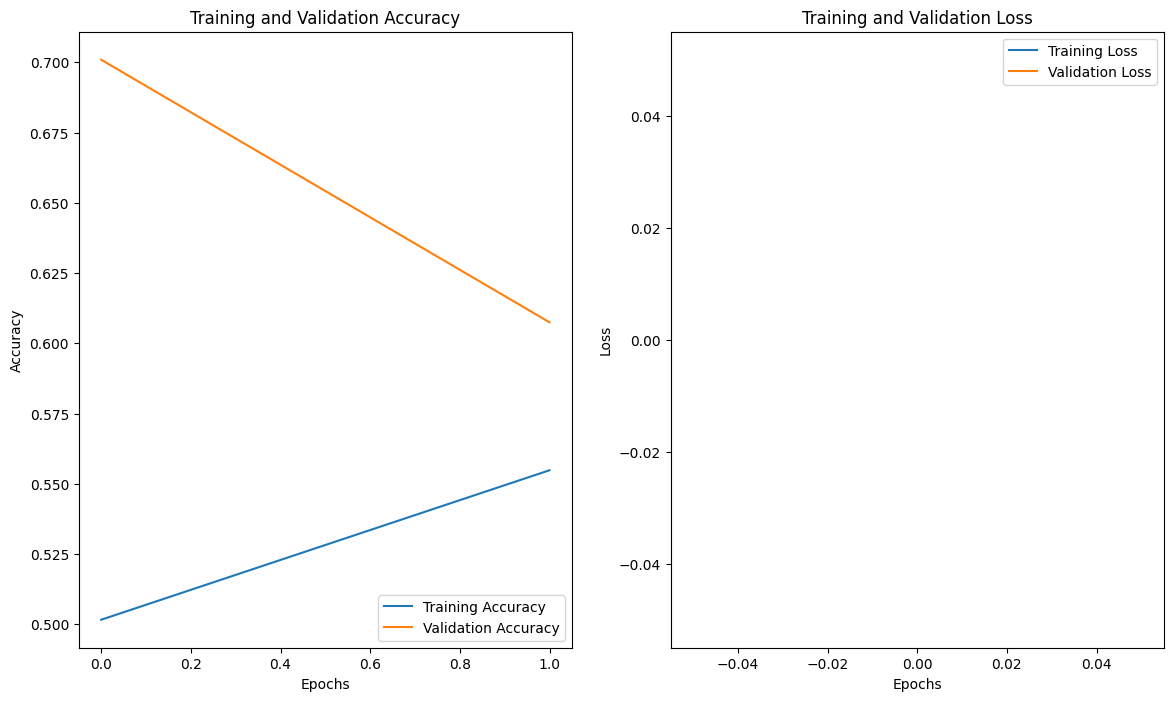

ITERATION: 1


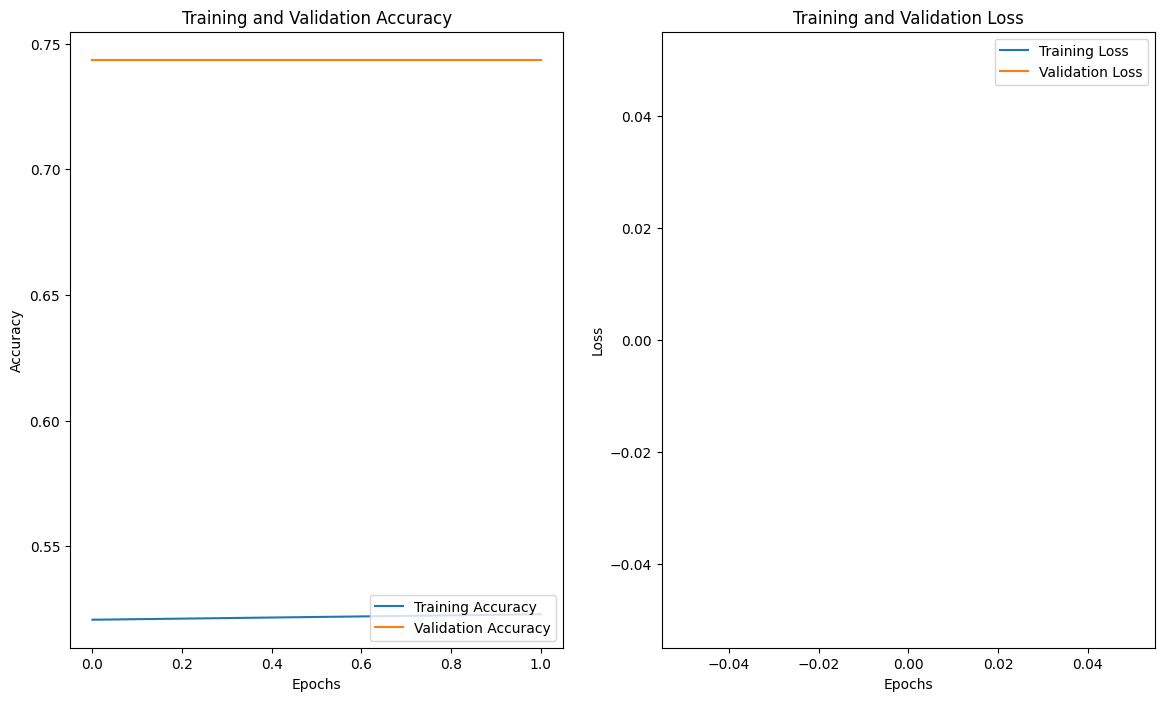

In [15]:
ii=0

for history in histories: 
    
    print(f'ITERATION: {ii}')
    CNN_lib.plot_train_eval(history,epochs)
    ii+= 1

In [16]:
loss,accuracy= [],[]

for model in modelos:

    test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=0) 

    loss.append(test_loss)
    accuracy.append(test_accuracy)

# ROC CURVE

4/4 [==============================] - 1s 192ms/step


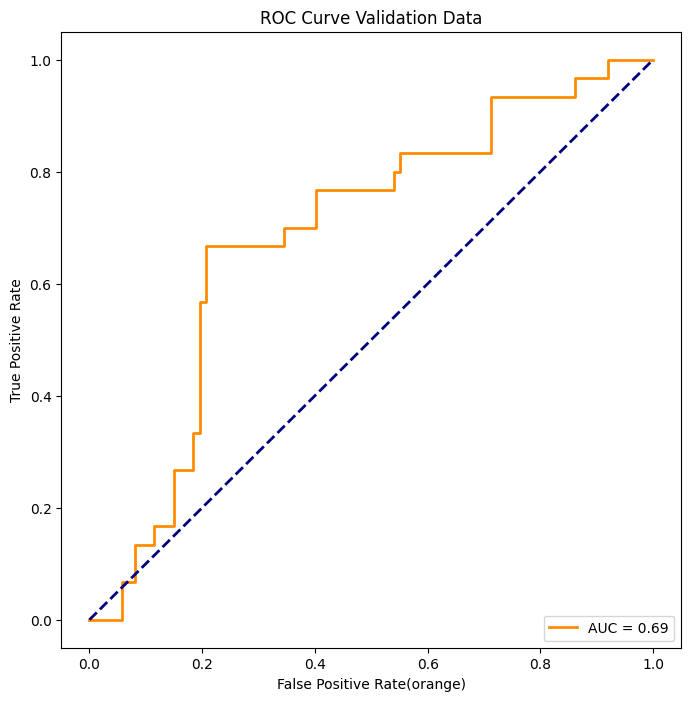

4/4 [==============================] - 1s 192ms/step


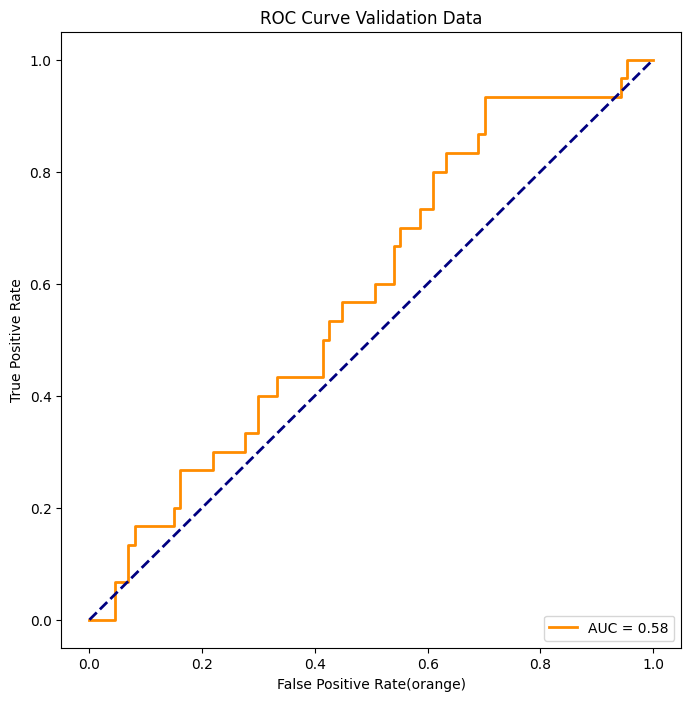

In [17]:
roc_aucs = []

for model in modelos:

    predictions = model.predict(X_eval)

    fpr_val, tpr_val, thresholds_val = roc_curve(Y_eval, predictions)
    roc_auc_false = auc(fpr_val, tpr_val)
    roc_aucs.append(roc_auc_false)

    CNN_lib.plot_roc_curve(fpr_val,tpr_val,roc_auc_false)

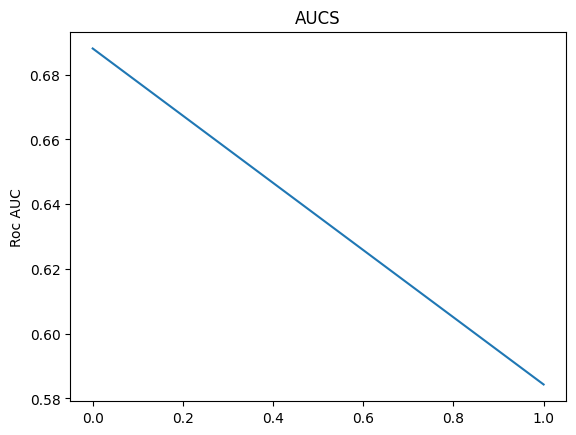

In [18]:
CNN_lib.list_plot(roc_aucs,title='AUCS',ylabel='Roc AUC')

In [19]:
print( 'AUC')
CNN_lib.stats(roc_aucs)

AUC
Valor medio:0.636
Desviación estandar:0.052
Varianza:0.003
Máximo:0.688
Mínimo:0.584
Mediana:0.636
Percentil 25:0.61
Percentil 75:0.662


In [20]:
print( 'LOSS')
CNN_lib.stats(loss)

LOSS
Valor medio:0.68
Desviación estandar:0.003
Varianza:0.0
Máximo:0.682
Mínimo:0.677
Mediana:0.68
Percentil 25:0.678
Percentil 75:0.681


In [21]:
print( 'ACCURACITY')
CNN_lib.stats(accuracy,rnd=4)

ACCURACITY
Valor medio:0.6923
Desviación estandar:0.0513
Varianza:0.0026
Máximo:0.7436
Mínimo:0.641
Mediana:0.6923
Percentil 25:0.6667
Percentil 75:0.7179


#  FORECAST EVALUATION

In [22]:

predictions_raw=[]

trsh=0.35

for pred in predictions:

    if pred < trsh:predictions_raw.append(0)
    else:predictions_raw.append(1)

predictions_raw=np.array(predictions_raw)


In [23]:
conf_matrix = confusion_matrix(Y_eval, predictions_raw)

print("Matriz de Confusión:")
print(conf_matrix)

classification_report_str = classification_report(Y_eval, predictions_raw)
print("Informe de Clasificación:")
print(classification_report_str)



Matriz de Confusión:
[[ 0 87]
 [ 0 30]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.26      1.00      0.41        30

    accuracy                           0.26       117
   macro avg       0.13      0.50      0.20       117
weighted avg       0.07      0.26      0.10       117



c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
true_classes = Y_eval  

correctly_classified_indices = np.where(predictions_raw == true_classes)[0]
incorrectly_classified_indices = np.where(predictions_raw != true_classes)[0]

correctly_classified_video_ids = [video_id for video_id in correctly_classified_indices]
incorrectly_classified_video_ids = [video_id for video_id in incorrectly_classified_indices]

num_zeros = np.count_nonzero(Y_eval == 0)
num_ones = np.count_nonzero(Y_eval == 1)


In [25]:
correct_labels_val = [Y_eval[i] for i in correctly_classified_indices]

print(correct_labels_val)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [26]:
print(f"OK, {len(correctly_classified_video_ids)}")
print(f"BAD, {len(incorrectly_classified_video_ids)}")
print(f'Ratio forecast: {len(correctly_classified_video_ids)/len(incorrectly_classified_video_ids)}')
print(f'Ratio labeling: {max([num_ones,num_zeros])/min([num_ones,num_zeros])}')

OK, 30
BAD, 87
Ratio forecast: 0.3448275862068966
Ratio labeling: 2.9
